# Quickstart

Assuming some level of knowledge with the blackjax style, the following is a minimum working example of a basic sampling problem 

In [ ]:
import jax
import jax.numpy as jnp
import blackjax
from blackjax.ns.utils import finalise
import tqdm 

rng_key = jax.random.PRNGKey(0)

loglikelihood_fn = lambda x: jax.scipy.stats.multivariate_normal.logpdf(x, jnp.ones(5), jnp.eye(5)*0.01)
logprior_fn = lambda x : jax.scipy.stats.multivariate_normal.logpdf(x, jnp.zeros(5), jnp.eye(5))

algo = blackjax.nss(
    logprior_fn=logprior_fn,
    loglikelihood_fn=loglikelihood_fn,
    num_delete=50,
    num_inner_steps=20,
)

rng_key, sampling_key, initialization_key = jax.random.split(rng_key, 3)
live = algo.init(jax.random.normal(initialization_key, (1000, 5)))
step = jax.jit(algo.step)

dead_points = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while (not live.logZ_live - live.logZ < -3):
        rng_key, subkey = jax.random.split(rng_key)
        live, dead = step(subkey, live)
        dead_points.append(dead)
        pbar.update(len(dead.particles))

ns_run = finalise(live, dead_points)

## Visualisation

This final state can be used for a number of computations, we display this more in [basic user walkthrough](basic.ipynb), for now we show how to dump the output into the pip installable anesthetic visualisation tool (https://github.com/handley-lab/anesthetic)

In [ ]:
import anesthetic
import numpy as np

nested_samples = anesthetic.NestedSamples(
    data = ns_run.particles,
    logL = ns_run.loglikelihood,
    logL_birth = ns_run.loglikelihood_birth,
)

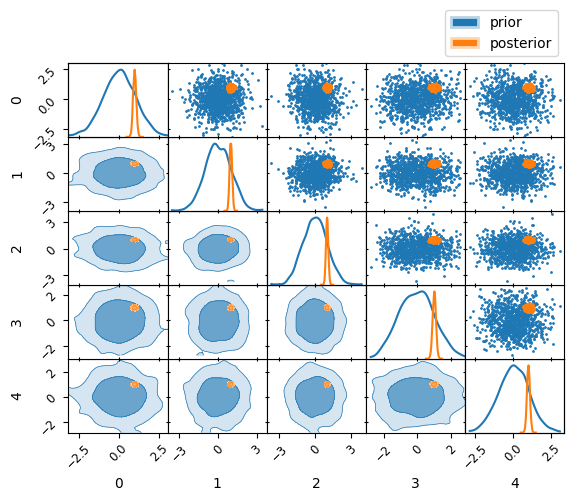

In [4]:
prior = nested_samples.set_beta(0.0).plot_2d(np.arange(5), label="prior")
post = nested_samples.plot_2d(prior, label= "posterior")
prior.iloc[-1, 0].legend(bbox_to_anchor=(len(prior), len(prior)), loc='lower right')
